Давайте подивимося, як LSTM можна використовувати для побудови нейронної мережі прогнозування часових рядів.

Будемо працювати з задачею прогнозування кількості пасажирів міжнародних авіаліній. З цим набором даних ми вже працювали в лекції "Time Series Analysis" і ви зможете порівняти результати :)

Задача полягає в тому, щоб за заданими роком і місяцем передбачити кількість пасажирів міжнародних авіаліній в одиницях виміру 1,000. Дані охоплюють період з січня 1949 року по грудень 1960 року, тобто 12 років, зі 144 спостереженнями.

Це регресійна задача. Тобто, знаючи кількість пасажирів (в тисячах) за останні місяці, можна передбачити, якою буде кількість пасажирів у наступному місяці. Набір даних має лише одну характеристику: "Кількість пасажирів" - `Passengers`.

Далі вже наведений код для читання даних, але нам їх ще треба буде трошки обробити.

### Imports

In [156]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import TensorDataset, DataLoader

### Load the data

In [157]:
# Завантаження даних
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv"
df = pd.read_csv(url)
df.set_index('Month', inplace=True)
display(df.head())

,Passengers
Month,
1949-01,112
1949-02,118
1949-03,132
1949-04,129
1949-05,121


### **Завдання 1.**
Створіть змінну типу `numpy.ndarray`, яка містить значення кількості пасажирів в форматі `float32`. Такий формат даних нам треба для тренування нейромережі.

In [158]:
num_pessengers = df.values.astype(np.float32)
num_pessengers[:5]

array([[112.],
       [118.],
       [132.],
       [129.],
       [121.]], dtype=float32)

Очікуваний результат:
```array([112., 118., 132., 129., 121.], dtype=float32)```

### **Завдання 2**. train, test
Розбийте дані на тренувальні і валідаційні у співвідношенні 67% йде у тренування, 33 - у валідацію. Памʼятаємо, що ми працюємо з tim series, відповідно, навчаємось на давніших, валідуємось - на новіших.

In [159]:
split_idx = int((len(num_pessengers)/3))
split_idx

48

In [160]:
train = num_pessengers[:-split_idx]
test = num_pessengers[-split_idx:]

In [161]:
print("train:", len(train))
print("test:", len(test))

train: 96
test: 48


### **Завдання 3**. create_dataset

Реалізуйте функцію `create_dataset`, яка перетворить одномірний часовий ряд (набір даних) у формат, придатний для тренування нейромережі.

Функція повинна приймати два аргументи:
- `dataset` — numpy-масив часового ряду,
- `lookback` — кількість попередніх кроків, які використовуватимуться для передбачення.

Функція повинна повернути два **тензори** PyTorch:
- `X` — набір ознак (вікно попередніх значень),
- `y` — цільові значення (наступні після вікна кроки).

Дані ми будемо подавати моделі в наступному форматі:
`
tensor([[112.],
        [118.],
        [132.],
        [129.],
        [121.]])
`
Відповідно першою розмірністю буде йти розмір вхідного батча, а другою - розмір вхідних даних і в нас це 1, бо лише одне значення на вході щоразу.

Після виконання завдання запустіть код нижче. Ми будемо передбачати на основі кількості пасажирів в попередній день кількість пасажирів в наступний, тому `lookback == 1`.

In [162]:
def create_dataset(dataset, lookback):
    X = torch.from_numpy(dataset[:-lookback])
    y = torch.from_numpy(dataset[lookback:])
    return X, y


    # X, y = [], []
    # for i in range(len(dataset) - lookback):
    #     X.append(dataset[i:i + lookback])
    #     y.append(dataset[i + lookback])
    # X = torch.tensor(np.array(X)).float()
    # y = torch.tensor(np.array(y)).float()
    # return X, y

In [163]:
lookback = 1
X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([95, 1]) torch.Size([95, 1])
torch.Size([47, 1]) torch.Size([47, 1])


Очікуваний результат:
```
torch.Size([95, 1]) torch.Size([95, 1])
torch.Size([47, 1]) torch.Size([47, 1])
```

### **Завдання 4**. AirModel

Зверніть увагу на розмірності в попередньому завданні.
За допомогою модуля `torch.nn` опишіть клас `AirModel`, який є нейронною мережею для прогнозування кількості пасажирів за допомогою LSTM.

1. **Конструктор класу** повинен приймати параметри `hidden_size`, `num_layers` та ініціювати шари:
   - LSTM-шар з наступними параметрами:
     - `input_size` — кожна точка часового ряду є окремим входом,,
     - `hidden_size` — заданий в конструкторі класу мережі,
     - `num_layers=1` — кількість шарів LSTM, задана в конструкторі мережі,
     - `batch_first=True` — визначає, що першим виміром є розмір батчу.
   - Лінійний шар (`nn.Linear`) для перетворення виходу LSTM на прогноз однієї точки.

2. **Метод forward** повинен виконувати наступні дії:
   - Передати вхідний тензор через LSTM-шар і отримати виходи (ігноруючи приховані стани).
   - Пропустити вихід LSTM через лінійний шар для отримання остаточного прогнозу.

Створіть об'єкт класу `AirModel` зі значеннями параметрів `hidden_size=50`, `num_layers=1` і протестуйте роботу моделі на вхідному тензорі `tensor([[112.]])`. На цьому етапі ми маємо переконатись, що модель здатна генерувати передбачення з рандомно ініційованими вагами.

In [189]:
class AirModel(nn.Module):
    def __init__(self, hidden_size, num_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size=lookback, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)

        self.fc = nn.Linear(hidden_size, out_features=1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out)
        return out

In [190]:
hidden_size = 50
num_layers = 1

model = AirModel(hidden_size, num_layers)
model

AirModel(
  (lstm): LSTM(1, 50, batch_first=True)
  (fc): Linear(in_features=50, out_features=1, bias=True)
)

In [191]:
model(torch.tensor([[112.]]))

tensor([[0.3183]], grad_fn=<AddmmBackward0>)

### **Завдання 5**. Dataloader

Створіть об'єкт DataLoader для завантаження даних, використовуючи тренувальні вибірки `X_train` та `y_train`. Ваш DataLoader повинен виконувати наступні вимоги:

1. Використовувати клас `TensorDataset`, щоб об'єднати тензори ознак `X_train` і цільових значень `y_train`.
2. Дані повинні завантажуватися невеликими батчами розміром 8 за допомогою параметра `batch_size`.
3. Використовувати параметр `shuffle=True`, щоб дані перемішувалися перед кожною епохою тренування.


In [192]:
batch_size = 8

train_ds = TensorDataset(X_train, y_train)
test_ds = TensorDataset(X_test, y_test)

train_dataloader = DataLoader(train_ds, batch_size, shuffle=True)
test_dataloader = DataLoader(test_ds, batch_size, shuffle=True)

### **Завдання 6**. Train the AirModel

1. Реалізуйте навчання нейронної мережі `AirModel` для прогнозування часових рядів, використовуючи Adam-оптимізатор та функцію втрат MSE (середньоквадратичну похибку).
2. Створіть цикл тренування для 2000 епох, у якому на кожній епосі:
   - Виконуйте крок тренування моделі (прямий прохід, обчислення похибки, зворотний прохід і оновлення ваг).
   - Підраховуйте середню похибку на кожному батчі даних і зберігайте її у списку `losses`.
3. Раз на 100 епох проводьте валідацію моделі:
   - Перевіряйте модель на тренувальних та тестових даних без оновлення ваг.
   - Обчислюйте корінь середньоквадратичної похибки (RMSE) для тренувальної та тестової вибірок і виводьте результати на екран.
   
**Примітка:**
- Використовуйте вже створений `DataLoader` для отримання батчів даних.
- Валідацію виконуйте в режимі `eval()`, вимикаючи обчислення градієнтів з `torch.no_grad()`.

**Приклад виходу:**
```
Epoch 0: train RMSE 12.3456, test RMSE 15.6789
Epoch 100: train RMSE 9.8765, test RMSE 12.3456
...
```

In [193]:
num_epochs = 2000

In [194]:
loss_fn = F.mse_loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [195]:
def train_eval(num_epochs, model, dataloader, loss_fn, optimizer):
    total_losses = []
    for epoch in range(num_epochs + 1):
        epoch_loss = 0
        model.train()

        for X, y in dataloader:
            # Zero gradients
            optimizer.zero_grad()

            # Compute the prediction error
            pred = model(X)
            loss = loss_fn(pred, y)

            # Backpropagation
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        # Calculate loss
        avg_loss = epoch_loss / len(dataloader)
        total_losses.append(avg_loss)

        if (epoch) % 100 == 0:
            model.eval()

            with torch.no_grad():
                # Compute the prediction error
                train_pred = model(X_train)
                train_rmse = torch.sqrt(loss_fn(train_pred, y_train))

                test_pred = model(X_test)
                test_rmse = torch.sqrt(loss_fn(test_pred, y_test))
            print(f"Epoch {epoch}: train RMSE {train_rmse ** 0.5 :.4f}, test RMSE {test_rmse ** 0.5 :.4f}")

    return total_losses

In [196]:
total_losses = train_eval(num_epochs, model, train_dataloader, loss_fn, optimizer)

Epoch 0: train RMSE 15.0187, test RMSE 20.5432
Epoch 100: train RMSE 13.4877, test RMSE 19.3998
Epoch 200: train RMSE 11.9758, test RMSE 18.2927
Epoch 300: train RMSE 10.6202, test RMSE 17.2891
Epoch 400: train RMSE 9.4707, test RMSE 16.3577
Epoch 500: train RMSE 8.6092, test RMSE 15.5397
Epoch 600: train RMSE 7.3863, test RMSE 14.5444
Epoch 700: train RMSE 6.5223, test RMSE 13.6147
Epoch 800: train RMSE 5.9217, test RMSE 12.8234
Epoch 900: train RMSE 5.5046, test RMSE 12.1163
Epoch 1000: train RMSE 5.3392, test RMSE 11.5202
Epoch 1100: train RMSE 5.0254, test RMSE 10.9587
Epoch 1200: train RMSE 5.0325, test RMSE 11.0027
Epoch 1300: train RMSE 5.0302, test RMSE 10.5799
Epoch 1400: train RMSE 4.8911, test RMSE 10.0617
Epoch 1500: train RMSE 4.7757, test RMSE 9.7872
Epoch 1600: train RMSE 4.7783, test RMSE 9.6384
Epoch 1700: train RMSE 4.8211, test RMSE 9.4262
Epoch 1800: train RMSE 4.7892, test RMSE 9.3321
Epoch 1900: train RMSE 4.7770, test RMSE 9.2370
Epoch 2000: train RMSE 4.7386, te

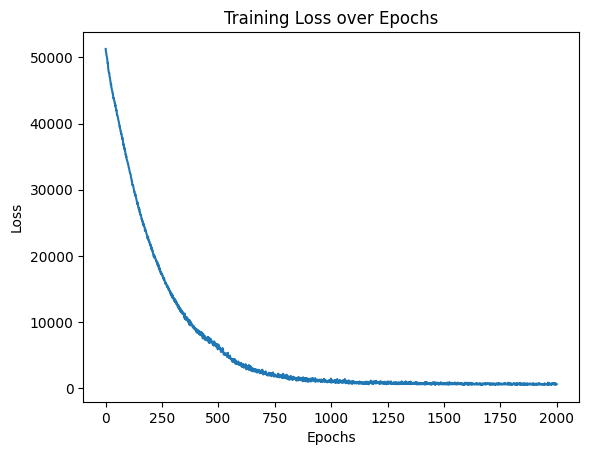

In [197]:
plt.plot(total_losses)
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

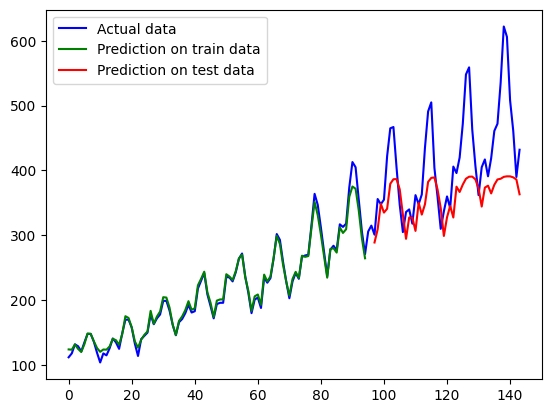

In [226]:
with torch.no_grad():
    plt.plot(num_pessengers, 'b', label='Actual data')

    train_plot = np.ones_like(num_pessengers) * np.nan
    train_plot[:len(X_train)] = model(X_train).numpy()
    plt.plot(train_plot, 'g', label='Prediction on train data')

    test_plot = np.ones_like(num_pessengers) * np.nan
    test_plot[-len(X_test):] = model(X_test).numpy()
    plt.plot(test_plot, 'r', label='Prediction on test data')
    plt.legend()
    plt.show()

The model performs well on train data, but worst on test data.